In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from glob import glob
from skimage.io import imread

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

import time
import copy
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import accuracy_score,roc_auc_score
import time
import copy
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print('Imports complete')


Imports complete


In [ ]:
labels=pd.read_csv("/content/drive/MyDrive/PRML project/Random_Sample/labels_sampled.csv")

In [ ]:
labels=labels.drop(['Unnamed: 0'],axis=1)

In [ ]:
labels

,id,label
0,11a68ca42b1d39a294f583bff78e02d3ba2fd351,1
1,f42dc1a114133887775d89a92c5572eedd151ce3,1
2,4377658e3f44232420819ed70f5d04c83cc2a183,1
3,c202ef01e9a4b002a58eb2284dbde87244e3c27a,0
4,1e8f4b97644bb654fe24e07c175f38d682520dd3,1
...,...,...
5495,da7e9c8880a251a7f3a7a69debdaa99fc63f88de,1
5496,9149e1c41d80e09eee71e88b4477b5eea17ea568,1
5497,c43409816e668aea392040ca457b159abc38c7e3,0
5498,53ef9a25f03b08ca735e136fa9e03a9349764aff,0


## What are Dimensions??

In [ ]:
! pip3 install raster2xyz

  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5964 sha256=4d728a3afff0e14979c9c3c87bcb067ff7f1d03b959eb3594eabe54d4e8e4413
  Stored in directory: /root/.cache/pip/wheels/07/4b/5d/fc666340cb735a7a79d149be0acd64dff8edec947dba612d70
Successfully built raster2xyz


In [ ]:
from raster2xyz.raster2xyz import Raster2xyz

input_raster = "/content/drive/MyDrive/PRML project/Random_Sample/Train/0013241318e68fd3eaca389171d248f9cee0af12.tif"
out_csv = "demo_out_xyz.csv"

rtxyz = Raster2xyz()
rtxyz.translate(input_raster, out_csv)

myRasterDF = pd.read_csv(out_csv)

myRasterDF


[2022-05-02 07:34:41 - INFO] - Getting geotransform and data...
[2022-05-02 07:35:22 - INFO] - Getting XYZ data...
[2022-05-02 07:35:22 - INFO] - Getting geotransformed coordinates...
[2022-05-02 07:35:22 - INFO] - Building XYZ data...
[2022-05-02 07:35:22 - INFO] - New XYZ (csv file) created...


,x,y,z
0,0.5,0.5,179
1,1.5,0.5,255
2,2.5,0.5,243
3,3.5,0.5,199
4,4.5,0.5,202
...,...,...,...
9211,91.5,95.5,226
9212,92.5,95.5,219
9213,93.5,95.5,223
9214,94.5,95.5,228


--------------------------------------------------------------------------------
**So one .tif image has dimensions (96x96x3) where 3 corresponds to the number of channels that the image has.**

## Complete Random Sampled load

In [ ]:
from PIL import Image

In [ ]:
IMG_WIDTH=96
IMG_HEIGHT=96
img_folder=r'/content/drive/MyDrive/PRML project/Random_Sample/Train'

In [ ]:
import random
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
def create_dataset_PIL(img_folder,labels):
    
    img_data_array=[]
    class_name=[]
    for file in range(len(labels)):
       
            image_path= os.path.join(img_folder,  labels['id'][file]+'.tif')
            image= np.array(Image.open(image_path))
            image = image.astype('float32')
            image /= 255  
            img_data_array.append(image)
            class_name.append(labels['label'][file])
    return img_data_array , class_name
PIL_img_data, class_name=create_dataset_PIL(img_folder,labels)

In [ ]:
len(PIL_img_data)

5500

In [ ]:
PIL_img_data[0].shape

(96, 96, 3)

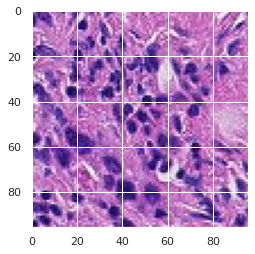

In [ ]:
a=PIL_img_data[0]
plt.imshow(a)

In [ ]:
PIL_img_data[0]

array([[[0.69411767, 0.34901962, 0.7411765 ],
        [0.8352941 , 0.53333336, 0.9098039 ],
        [0.54901963, 0.3137255 , 0.6666667 ],
        ...,
        [0.8901961 , 0.7176471 , 1.        ],
        [0.2901961 , 0.15294118, 0.52156866],
        [0.21960784, 0.09411765, 0.5137255 ]],

       [[0.5137255 , 0.21568628, 0.60784316],
        [0.68235296, 0.41960785, 0.8       ],
        [0.40784314, 0.19215687, 0.5568628 ],
        ...,
        [0.8862745 , 0.72156864, 0.96862745],
        [0.72156864, 0.56078434, 0.8666667 ],
        [0.27058825, 0.09411765, 0.45882353]],

       [[0.32156864, 0.10196079, 0.48235294],
        [0.47843137, 0.26666668, 0.6431373 ],
        [0.49411765, 0.29803923, 0.67058825],
        ...,
        [0.8627451 , 0.70980394, 0.88235295],
        [0.7647059 , 0.5647059 , 0.79607844],
        [0.4745098 , 0.23137255, 0.5176471 ]],

       ...,

       [[0.45882353, 0.4117647 , 0.67058825],
        [0.16078432, 0.06666667, 0.3647059 ],
        [0.4392157 , 0

In [ ]:
flatten=[]
for i in PIL_img_data:
  flatten.append(i.flatten())
flatten = np.array(flatten)
flatten.shape

(5500, 27648)

DONT

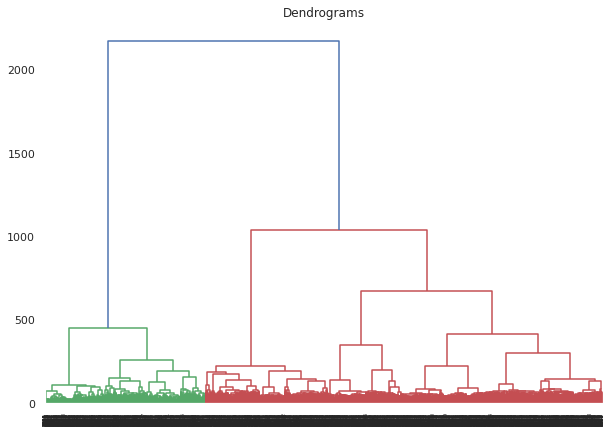

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(flatten, method='ward'))

## Models

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(flatten,class_name,stratify=class_name,train_size=0.8,random_state=10)


In [ ]:
X_PIL_train, X_PIL_test, y_PIL_train, y_PIL_test=train_test_split(PIL_img_data ,class_name,stratify=class_name,train_size=0.8,random_state=10)

In [ ]:
len(X_PIL_train)

4400

### Linear Support Vector Classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       654
           1       0.52      0.57      0.54       446

    accuracy                           0.61      1100
   macro avg       0.60      0.61      0.60      1100
weighted avg       0.62      0.61      0.62      1100



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.77      0.53      0.62       654
           1       0.53      0.77      0.62       446

    accuracy                           0.62      1100
   macro avg       0.65      0.65      0.62      1100
weighted avg       0.67      0.62      0.62      1100



### RBF SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
rbf = make_pipeline(StandardScaler(), SVC(random_state=0, gamma='auto'))
rbf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', random_state=0))])

In [ ]:
y_pred=rbf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       654
           1       0.77      0.68      0.72       446

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.78      1100
weighted avg       0.79      0.79      0.79      1100



### Convolution Neural Network

In [ ]:
XX=np.asarray(X_PIL_train)
YY=np.asarray(y_PIL_train)
xx=np.asarray(X_PIL_test)
yy=np.asarray(y_PIL_test)
xx.shape

(1100, 96, 96, 3)

In [ ]:
x1=np.swapaxes(XX,1,3)
x1=np.swapaxes(x1,2,3)
x1.shape

(4400, 3, 96, 96)

In [ ]:
x2=np.swapaxes(xx,1,3)
x2=np.swapaxes(x2,2,3)
x2.shape

(1100, 3, 96, 96)

In [4]:
class Dataset(Dataset):
    def __init__(self, X,y, transform=None):
        super().__init__()
        self.X = torch.from_numpy(X).float()
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        image= self.X[index]
        label =self.y[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
batch_size = 128
valid_size = 0.1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
num_classes = 2
learning_rate = 0.01

In [ ]:
X_PIL_train[0].shape

(96, 96, 3)

In [ ]:
len(y_PIL_test)

1100

In [ ]:
len(x2)

1100

In [ ]:
trans_train = transforms.Compose([transforms.ToPILImage(),                   
                                  transforms.Pad(64, padding_mode='reflect'),   
                                  transforms.RandomHorizontalFlip(),            
                                  transforms.RandomVerticalFlip(),            
                                  transforms.RandomRotation(20),             
                                  transforms.ToTensor(),                     
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])    

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [ ]:
dataset_train = Dataset(X=x1, y=y_PIL_train, transform=trans_train)
dataset_valid = Dataset(X=x2, y=y_PIL_test, transform=trans_valid)

train_loader = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc(x)
        return x

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNor

In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
len(train_loader)

35

In [ ]:
train_losses = []
val_losses = []
train_auc = []
val_auc = []
train_auc_epoch = []
val_auc_epoch = []
best_acc = 0.0
min_loss = np.Inf

since = time.time()

for e in range(num_epochs):
    
    train_loss = 0.0
    val_loss = 0.0
    
    # Train the model
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Loss and accuracy
        train_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(y_actual, y_pred))
    
    # Evaluate the model
    model.eval()
    for i, (images, labels) in enumerate(tqdm(valid_loader, total=int(len(valid_loader)))):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Loss and accuracy
        val_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        y_pred = outputs[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))
    
    # Average losses and accuracies
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(valid_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    training_auc = np.mean(train_auc)
    validation_auc = np.mean(val_auc)
    train_auc_epoch.append(training_auc)
    val_auc_epoch.append(validation_auc)
    
    # Updating best validation accuracy
    if best_acc < validation_auc:
        best_acc = validation_auc
        
    # Saving best model
    if min_loss >= val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        min_loss = val_loss
    
    print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, num_epochs,train_loss,val_loss, training_auc,validation_auc))
    print('-' * 10)
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation accuracy: {:4f}'.format(best_acc))

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 1/30 Train loss: 0.466297,Validation loss: 0.527571, Train AUC: 0.8693  Validation AUC: 0.8652
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 2/30 Train loss: 0.449777,Validation loss: 0.454866, Train AUC: 0.8749  Validation AUC: 0.8755
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 3/30 Train loss: 0.436531,Validation loss: 0.600795, Train AUC: 0.8794  Validation AUC: 0.8860
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 4/30 Train loss: 0.410432,Validation loss: 0.420889, Train AUC: 0.8837  Validation AUC: 0.8925
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 5/30 Train loss: 0.397470,Validation loss: 0.384555, Train AUC: 0.8872  Validation AUC: 0.8960
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 6/30 Train loss: 0.390196,Validation loss: 0.372141, Train AUC: 0.8906  Validation AUC: 0.8991
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 7/30 Train loss: 0.390907,Validation loss: 0.380201, Train AUC: 0.8928  Validation AUC: 0.9014
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 8/30 Train loss: 0.396269,Validation loss: 0.390066, Train AUC: 0.8941  Validation AUC: 0.9038
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 9/30 Train loss: 0.378797,Validation loss: 0.370251, Train AUC: 0.8961  Validation AUC: 0.9058
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 10/30 Train loss: 0.378245,Validation loss: 0.385717, Train AUC: 0.8980  Validation AUC: 0.9054
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 11/30 Train loss: 0.368174,Validation loss: 0.425150, Train AUC: 0.8996  Validation AUC: 0.9041
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 12/30 Train loss: 0.364626,Validation loss: 0.349896, Train AUC: 0.9015  Validation AUC: 0.9058
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 13/30 Train loss: 0.351633,Validation loss: 0.329784, Train AUC: 0.9032  Validation AUC: 0.9076
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 14/30 Train loss: 0.364649,Validation loss: 0.342822, Train AUC: 0.9043  Validation AUC: 0.9091
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 15/30 Train loss: 0.364018,Validation loss: 0.344749, Train AUC: 0.9054  Validation AUC: 0.9102
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 16/30 Train loss: 0.350692,Validation loss: 0.334253, Train AUC: 0.9067  Validation AUC: 0.9114
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 17/30 Train loss: 0.336987,Validation loss: 0.324282, Train AUC: 0.9081  Validation AUC: 0.9126
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 18/30 Train loss: 0.336167,Validation loss: 0.331419, Train AUC: 0.9094  Validation AUC: 0.9134
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 19/30 Train loss: 0.321362,Validation loss: 0.459847, Train AUC: 0.9109  Validation AUC: 0.9135
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 20/30 Train loss: 0.318157,Validation loss: 0.295694, Train AUC: 0.9122  Validation AUC: 0.9151
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 21/30 Train loss: 0.310323,Validation loss: 0.361224, Train AUC: 0.9136  Validation AUC: 0.9160
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 22/30 Train loss: 0.324435,Validation loss: 0.384263, Train AUC: 0.9146  Validation AUC: 0.9157
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 23/30 Train loss: 0.324287,Validation loss: 0.390485, Train AUC: 0.9155  Validation AUC: 0.9169
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 24/30 Train loss: 0.307341,Validation loss: 0.352743, Train AUC: 0.9166  Validation AUC: 0.9181
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 25/30 Train loss: 0.311588,Validation loss: 0.355709, Train AUC: 0.9177  Validation AUC: 0.9183
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 26/30 Train loss: 0.297237,Validation loss: 0.336049, Train AUC: 0.9189  Validation AUC: 0.9189
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 27/30 Train loss: 0.298133,Validation loss: 0.303723, Train AUC: 0.9198  Validation AUC: 0.9200
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 28/30 Train loss: 0.291568,Validation loss: 0.288631, Train AUC: 0.9209  Validation AUC: 0.9211
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 29/30 Train loss: 0.298117,Validation loss: 0.308273, Train AUC: 0.9218  Validation AUC: 0.9217
  
----------


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

EPOCH 30/30 Train loss: 0.284956,Validation loss: 0.286712, Train AUC: 0.9228  Validation AUC: 0.9227
  
----------
Training completed in 22m 57s
Best validation accuracy: 0.922723


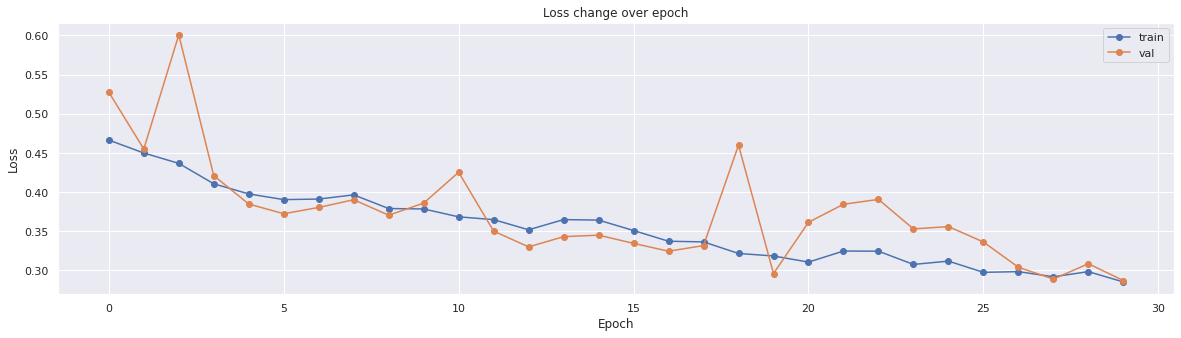

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

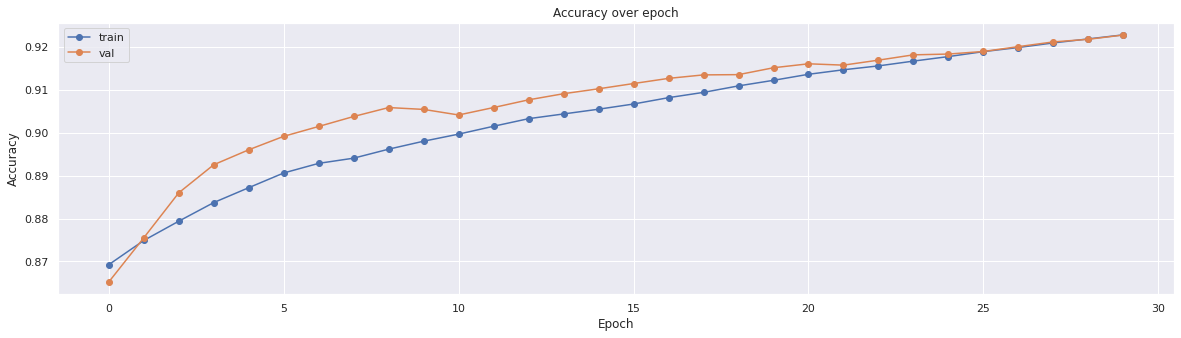

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()

In [ ]:
def feature_visualize(model,x):
  x=x.to(device)
  x1 = model.layer1(x)
  x2 = model.layer2(x1)
  x3 = model.layer3(x2)
  x4 = model.layer4(x3)
  x5 = model.layer5(x4)
  x6 = model.avg(x5)
  plt.subplot(1,6,1)
  img = x1[0][0].squeeze().cpu().detach().numpy()
  plt.imshow(img)
  plt.subplot(1,6,2)
  img = x2[0][0].permute(1,2,0).squeeze().cpu().detach().numpy()
  plt.imshow(img)
  plt.subplot(1,6,3)
  img = x3[0][0].permute(1,2,0).squeeze().cpu().detach().numpy()
  plt.imshow(img)
  plt.subplot(1,6,4)
  img = x4[0][0].permute(1,2,0).squeeze().cpu().detach().numpy()
  plt.imshow(img)
  plt.subplot(1,6,5)
  img = x5[0][0].permute(1,2,0).squeeze().cpu().detach().numpy()
  plt.imshow(img)
  plt.subplot(1,6,6)
  img = x6[0][0].permute(1,2,0).squeeze().cpu().detach().numpy()
  plt.imshow(img)
  plt.show()

In [ ]:
from torchvision.transforms import functional as F



In [ ]:
features, labels = next(iter(valid_loader))
feature_visualize(model,features)



RuntimeError: ignored

In [ ]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [ ]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

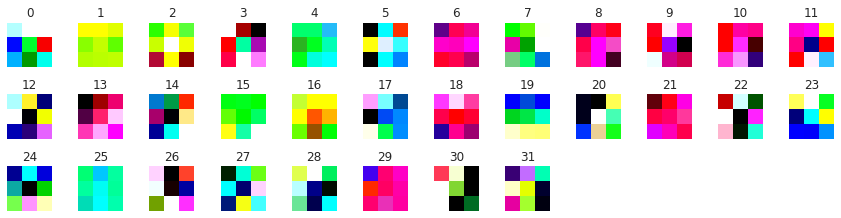

In [ ]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.layer1[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.layer1[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor.cpu())
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        

plot_weights(model, 0, single_channel = False)

In [ ]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.layer2[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.layer2[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor.cpu())
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor.cpu())
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        

plot_weights(model, 0)

Can only plot weights with three channels with single channel = False


In [ ]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.layer3[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.layer3[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor.cpu())
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor.cpu())
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        

plot_weights(model, 0)

Can only plot weights with three channels with single channel = False


In [ ]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.layer4[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.layer4[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor.cpu())
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor.cpu())
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        

plot_weights(model, 0)

In [ ]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.layer5[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.layer5[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor.cpu())
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor.cpu())
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")
        

plot_weights(model, 0)

Can only plot weights with three channels with single channel = False
